In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from hp_pred.experiments import load_labelized_cases
from hp_pred.test_model import TestModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\pret.PORTPRETLAMIH11\Desktop\test\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and format data

In [2]:
# import the data frame and add the meta data to the segments

dataset_name = 'chu_dataset'
model_filename = 'xgb_30_s.json'

In [3]:
data = pd.read_parquet(f'data/datasets/{dataset_name}/cases', dtype_backend='pyarrow')
static = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data = data.merge(static, on='caseid')
test = data[data['split'] == 'test']
train = data[data['split'] == 'train'] # training set in only used to calibrate the baseline


FileNotFoundError: [Errno 2] No such file or directory: 'data/datasets/chu_dataset/cases'

## Evaluation

This section should take about 10 minutes to complete.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of points in the test data: 25049
Prevalence of hypotension: 19.40%
Test data loaded
Baseline test:


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


Model 0 test:


100%|██████████| 200/200 [01:02<00:00,  3.20it/s]




Results for 30_s_model
Baseline
AUC: 0.66 (0.00)
AP: 0.32 (0.01)
AUPRC: 0.38 (0.01)
Threshold: 67.13 [64.87, 68.04]
Recall: 26.8% [3.1%, 37.1%]
Precision: 48.2% [47.1%, 50.2%]
Specificity: 93.7% [72.4%, 95.0%]
NPV: 98.7% [97.7%, 98.9%]
F1-score: 34.4% [5.8%, 41.4%]


Model 0
AUC: 0.70 (0.00)
AP: 0.36 (0.01)
AUPRC: 0.44 (0.01)
Threshold: 0.32 [0.31, 0.32]
Recall: 26.8% [26.7%, 26.9%]
Precision: 50.0% (2.0%)
Specificity: 93.9% (0.5%)
NPV: 98.7% (0.0%)
F1-score: 34.9% (0.5%)




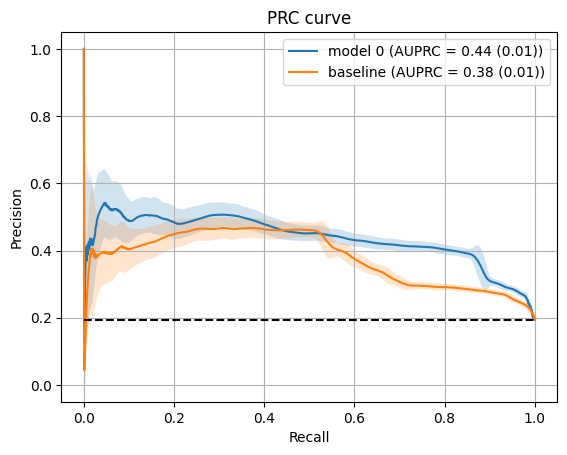

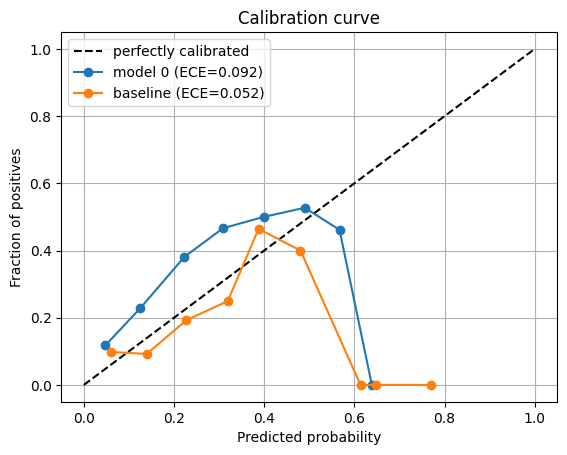

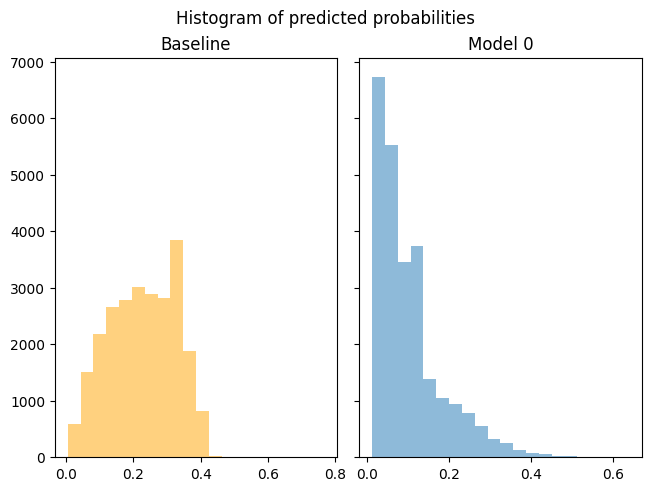

In [24]:
tester = TestModel(
    test,
    train,
    [model_filename], # a list of model can be provided
    output_name='30_s_model',
)
tester.run(True, True)

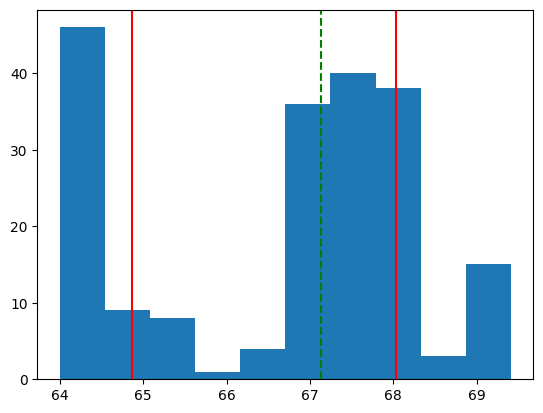

In [25]:
plt.hist(tester.dict_results_baseline['threshold_opt'])
# plot quantiles
plt.axvline(np.quantile(tester.dict_results_baseline['threshold_opt'], 0.25), color='r')
plt.axvline(np.quantile(tester.dict_results_baseline['threshold_opt'], 0.75), color='r')
plt.axvline(np.quantile(tester.dict_results_baseline['threshold_opt'], 0.5), color='g', linestyle='--')

plt.show()



In [26]:
# save data for paper plots
recall = np.linspace(0, 1, 1000)
baseline_precision_mean, baseline_precision_std = tester.dict_results_baseline['precision'].mean(
                0), tester.dict_results_baseline['precision'].std(0)

df_baseline = pd.DataFrame({
    'recall': recall,
    'precision_mean': baseline_precision_mean,
    'precision_std': baseline_precision_std,
})
if 'chu' not in dataset_name:
    df_baseline[::5].to_csv('output/baseline_precision_recall.csv', index=False)
else:
    df_baseline[::5].to_csv('output/chu_baseline_precision_recall.csv', index=False)


model_precision_mean, model_precision_std = tester.dict_results_model[0]['precision'].mean(
                0), tester.dict_results_model[0]['precision'].std(0)

df_model = pd.DataFrame({
    'recall': recall,
    'precision_mean': model_precision_mean,
    'precision_std': model_precision_std,
})
if 'chu' not in  dataset_name:
    df_model[::5].to_csv('output/xgboost_precision_recall_30_s.csv', index=False)
else:
    df_model[::5].to_csv('output/chu_xgboost_precision_recall_30_s.csv', index=False)

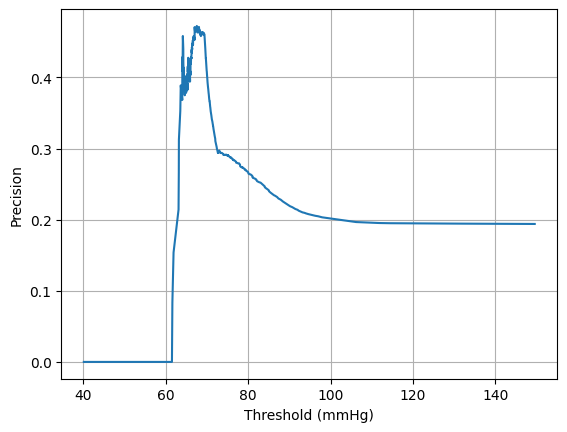

In [27]:
from hp_pred.experiments import precision_event_recall

baseline_prob = 1 - test['last_map_value'].values / 120

precision, recall, th = precision_event_recall(test['label'].values, baseline_prob, test['label_id'].values)
plt.plot((1-th)*120, precision[1:], label='Model')
plt.grid()
plt.xlabel('Threshold (mmHg)')
plt.ylabel('Precision')
plt.savefig('output/S1.pdf', bbox_inches='tight')
plt.show()

FixedFormatter should only be used together with FixedLocator


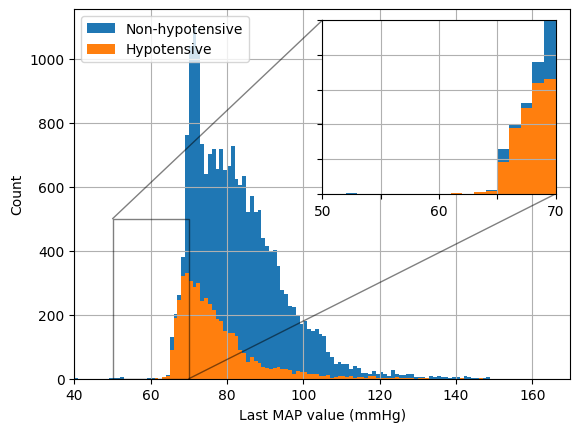

In [28]:
# test = test.query('last_map_value < 65')

alpha = 1
plt.hist(test.query('label==0').last_map_value, bins=np.arange(40,150), alpha=alpha, label='Non-hypotensive')
plt.hist(test.query('label==1').last_map_value, bins=np.arange(40,150), alpha=alpha, label='Hypotensive')

plt.grid()
plt.xlabel('Last MAP value (mmHg)')
plt.ylabel('Count')
plt.xlim(40, 170)

x1, x2, y1, y2 = 50, 70, 0, 500  # subregion of the original image
ax = plt.gca()
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2),  xticklabels=[50,'',60,'',70], yticklabels=[])
axins.grid()
axins.hist(test.query('label==0').last_map_value, bins=np.arange(40,150), alpha=alpha)
axins.hist(test.query('label==1').last_map_value, bins=np.arange(40,150), alpha=alpha)


ax.indicate_inset_zoom(axins, edgecolor="black")


plt.legend(loc='upper left')
plt.savefig('output/S2.pdf', bbox_inches='tight')
plt.show()
# test.query('last_map_value < 43').label.count()

## SHAP interpretations

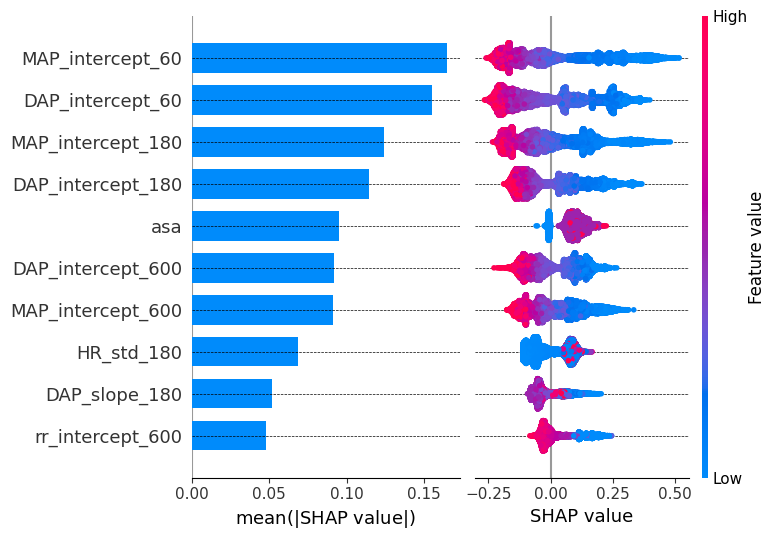

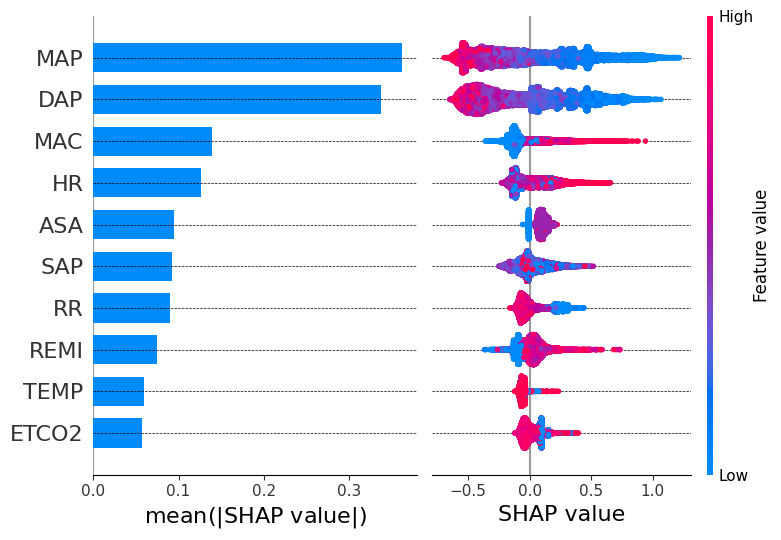

In [29]:
tester.compute_shap_value()
tester.plot_shap_values()
tester.group_shap_values()
tester.plot_shap_grouped()

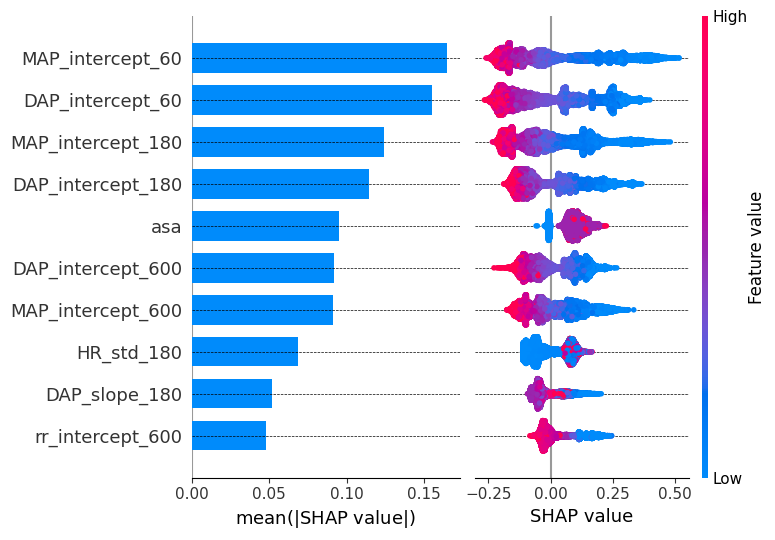

In [32]:
import shap
nb_max_feature = 10
test_data = tester.test_data[tester.features_names]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(tester.shap_values, test_data, feature_names=tester.features_names,
                    show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)')
names = plt.gca().get_yticklabels()
names = [name.get_text().replace("constant", "intercept") for name in names]
names = [name.replace("mbp", "MAP") for name in names]
names = [name.replace("sbp", "SAP") for name in names]
names = [name.replace("dbp", "DAP") for name in names]
names = [name.replace("hr", "HR") for name in names]
names = [name.replace("rf_ct", "RF_CT") for name in names]
plt.gca().set_yticklabels(names)
plt.subplot(1, 2, 2)
shap.summary_plot(tester.shap_values, test_data, feature_names=tester.features_names,
                    show=False, max_display=nb_max_feature)
# remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
# add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)

plt.savefig('output/shap_xgboost_chu.pdf', bbox_inches='tight')
plt.show()

In [34]:
0.15/0.24

0.625

## Exemple of cases


In [31]:
# plot 3 random cases with the corresponding decision function

np.random.seed(1)
cases = np.random.choice(test['caseid'].unique(), 5, replace=False)
model =tester.model[0]
features_names = tester.features_names
for case in cases:
    raw_case = load_labelized_cases(dataset_path=Path(f'data/datasets/{dataset_name}/'), caseid=int(case))

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=features_names)
    x_test = segment_data[features_names]
    y_pred = model.predict_proba(x_test)[:,1]

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot([t.hour * 60 + t.minute + t.second /60 for t in (segment_data[segment_data.label>0].time)] ,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot([t.hour * 60 + t.minute + t.second / 60 for t in (segment_data[segment_data.label==00].time)] ,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    # plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()




FileNotFoundError: [Errno 2] No such file or directory: 'data/cases_chu/case-0073.parquet'